In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn import metrics

from sklearn.model_selection import ShuffleSplit

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')


varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

In [3]:
## if it is interdiscipilinary then -1 otherwise 0 (Normal data)
manualtag['interdiscipilinary']=-1
manualtag.loc[manualtag.apply(lambda x: (x['Category']==x['Category_1']) & (pd.isnull(x['Category_2'])) , axis=1),'interdiscipilinary']=0

In [4]:
manualtag.groupby(['Category','Category_1']).count()

Translates  \
Category                       Category_1                                   
Engineering Sciences           Engineering Sciences                    10   
                               Humanities and Social Sciences           3   
                               Life Sciences                            2   
Humanities and Social Sciences Engineering Sciences                     3   
                               Humanities and Social Sciences           8   
                               Life Sciences                            4   
Life Sciences                  Life Sciences                            9   
                               Natural Sciences                         2   
Natural Sciences               Engineering Sciences                     1   
                               Humanities and Social Sciences           1   
                               Life Sciences                            3   
                               Natural Sciences                         4   

                                                               Category_2  \
Category                       Category_1                                   
Engineering Sciences           Engineering Sciences                     1   
                               Humanities and Social Sciences           0   
                               Life Sciences                            1   
Humanities and Social Sciences Engineering Sciences                     0   
                               Humanities and Social Sciences           0   
                               Life Sciences                            2   
Life Sciences                  Life Sciences                            0   
                               Natural Sciences                         0   
Natural Sciences               Engineering Sciences                     0   
                               Humanities and Social Sciences           1   
                               Life Sciences                            0   
                               Natural Sciences                         1   

                                                               Unnamed: 4  \
Category                       Category_1                                   
Engineering Sciences           Engineering Sciences                     0   
                               Humanities and Social Sciences           0   
                               Life Sciences                            0   
Humanities and Social Sciences Engineering Sciences                     0   
                               Humanities and Social Sciences           0   
                               Life Sciences                            0   
Life Sciences                  Life Sciences                            0   
                               Natural Sciences                         0   
Natural Sciences               Engineering Sciences                     0   
                               Humanities and Social Sciences           0   
                               Life Sciences                            0   
                               Natural Sciences                         0   

                                                               interdiscipilinary  
Category                       Category_1                                          
Engineering Sciences           Engineering Sciences                            10  
                               Humanities and Social Sciences                   3  
                               Life Sciences                                    2  
Humanities and Social Sciences Engineering Sciences                             3  
                               Humanities and Social Sciences                   8  
                               Life Sciences                                    4  
Life Sciences                  Life Sciences                                    9  
                               Natural Sciences                       

## 1.1 Word Embedding

In [5]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list        
        
## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [6]:
## creating a tagged document
DescDict=make_bigram([[x for x in str(i).split()] for i in df.PreProcessedDescription])

#tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [7]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-02-21 23:24:54.192919 Started
2020-02-21 23:32:17.691294 Completed


In [8]:
## Validating the model response for random words 

modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.57 'biological system'
    2. 0.55 'learn'
    3. 0.55 'host'
    4. 0.54 'natural environment'
    5. 0.54 'highly'
    6. 0.53 'learning'
    7. 0.52 'environmental condition'
    8. 0.52 'bacteria'
    9. 0.51 'provide unique'
    10. 0.51 'world'
    11. 0.51 'insect'
    12. 0.51 'behaviour'
    13. 0.50 'live'
    14. 0.50 'animal'
    15. 0.48 'habitat'
    16. 0.48 'pathogen'
    17. 0.48 'situation'
    18. 0.48 'motion'
    19. 0.48 'need understand'
    20. 0.47 'self organise'


## 1.2. PCA

In [9]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 76.85723304748535


In [256]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

SubjectAreaIds=pd.DataFrame(enumerate(merged_data.SubjectArea.unique()),columns=['SubjectAreaId','SubjectArea2'])
finalcols=merged_data.columns.tolist()+['SubjectAreaId']
merged_data=merged_data.merge(SubjectAreaIds, how='left',left_on='SubjectArea',right_on='SubjectArea2')[finalcols]

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

# 2. DBScan

In [140]:
#### Hyper parameter ####
    # eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples -The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
param_dict={'eps':np.linspace(2.5,4.3,8) ,'min_samples':[3,5,10,15,20,40,45]}

In [141]:
i_category=[]
i_eps=[]
i_min_samples=[]
silhouette_scores=[]
number_outliers=[]
recalls=[]


FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']

for cat in merged_data.Category.unique():
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    e=0
    for eps in param_dict['eps']:
        for min_samples in param_dict['min_samples']:

            clusterer = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=4)
            preds = clusterer.fit_predict(CategoricalDS)
            pred_uniq=len(pd.Series(preds).unique())
            
            if(pred_uniq==2):
                score = silhouette_score(CategoricalDS, preds, metric='euclidean')

                merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
                noo=merged_data.loc[(merged_data.Category==cat) & (merged_data.DBScanCluster==-1),'DBScanCluster'].count()

                manualtag_result_1=manualtag[manualtag.Category==cat][['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','DBScanCluster']]           
                recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster, pos_label=-1),2)
            else:
                score=0
                noo=0
                recall=0
            
            i_category.append(cat)
            i_eps.append(eps)
            i_min_samples.append(min_samples)
            silhouette_scores.append(score)
            number_outliers.append(noo)
            recalls.append(recall)
        e=e+1
        print(cat,': eps',e,'/',len(param_dict['eps']),'completed')  

Natural Sciences : eps 1 / 8 completed
Natural Sciences : eps 2 / 8 completed
Natural Sciences : eps 3 / 8 completed
Natural Sciences : eps 4 / 8 completed
Natural Sciences : eps 5 / 8 completed
Natural Sciences : eps 6 / 8 completed
Natural Sciences : eps 7 / 8 completed
Natural Sciences : eps 8 / 8 completed
Humanities and Social Sciences : eps 1 / 8 completed
Humanities and Social Sciences : eps 2 / 8 completed
Humanities and Social Sciences : eps 3 / 8 completed
Humanities and Social Sciences : eps 4 / 8 completed
Humanities and Social Sciences : eps 5 / 8 completed
Humanities and Social Sciences : eps 6 / 8 completed
Humanities and Social Sciences : eps 7 / 8 completed
Humanities and Social Sciences : eps 8 / 8 completed
Engineering Sciences : eps 1 / 8 completed
Engineering Sciences : eps 2 / 8 completed
Engineering Sciences : eps 3 / 8 completed
Engineering Sciences : eps 4 / 8 completed
Engineering Sciences : eps 5 / 8 completed
Engineering Sciences : eps 6 / 8 completed
Engine

In [144]:
Param_tuning=pd.DataFrame({
    'i_category':i_category,
    'i_eps':i_eps,
    'i_min_samples':i_min_samples,
    'silhouette_scores':silhouette_scores,
    'number_outliers':number_outliers,
    'recalls':recalls
})

In [145]:
Param_tuning.sort_values(by=['i_category','recalls','silhouette_scores','number_outliers'],ascending=False)

,i_category,i_eps,i_min_samples,silhouette_scores,number_outliers,recalls
22,Natural Sciences,3.142857,5,0.232947,1996,1.00
23,Natural Sciences,3.142857,10,0.219685,2166,1.00
24,Natural Sciences,3.142857,15,0.212051,2286,1.00
25,Natural Sciences,3.142857,20,0.205652,2389,1.00
26,Natural Sciences,3.142857,40,0.182640,2746,1.00
27,Natural Sciences,3.142857,45,0.178226,2807,1.00
17,Natural Sciences,2.928571,15,0.137515,3549,1.00
18,Natural Sciences,2.928571,20,0.129643,3715,1.00
19,Natural Sciences,2.928571,40,0.108845,4264,1.00
20,Natural Sciences,2.928571,45,0.103611,4375,1.00


In [240]:
Param_tuning.to_csv(Path+'ParamTuning_DBScanV3.csv', index=False)

In [146]:
bestparam={}
for cat in merged_data.Category.unique():
    bestparams=Param_tuning[(Param_tuning['number_outliers']>500) & (Param_tuning['i_category']==cat)].sort_values(by=['recalls','silhouette_scores','number_outliers'],ascending=False).head(1).values[0]
    bestparam[cat]={'eps':bestparams[1],'minsample':bestparams[2]}

In [147]:
bestparam={'Natural Sciences': {'eps': 3.142857142857143, 'minsample': 5},
 'Humanities and Social Sciences': {'eps': 2.7142857142857144,
  'minsample': 10},
 'Engineering Sciences': {'eps': 3.142857142857143, 'minsample': 15},
 'Life Sciences': {'eps': 3.7857142857142856, 'minsample': 10}}
#bestparam= {'Natural Sciences': {'eps': 3.7714285714285714, 'minsample': 30},
# 'Humanities and Social Sciences': {'eps': 2.785714,
#  'minsample': 15},
# 'Engineering Sciences': {'eps': 3.7714285714285714, 'minsample': 15},
# 'Life Sciences': {'eps': 3.928571428571429, 'minsample': 30}}

{'Natural Sciences': {'eps': 3.142857142857143, 'minsample': 5},
 'Humanities and Social Sciences': {'eps': 2.7142857142857144,
  'minsample': 10},
 'Engineering Sciences': {'eps': 3.142857142857143, 'minsample': 15},
 'Life Sciences': {'eps': 3.7857142857142856, 'minsample': 10}}

In [109]:
#FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']
#cat='Humanities and Social Sciences'
#
#CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
#clusterer = DBSCAN(eps=bestparam[cat]['eps'], min_samples=bestparam[cat]['minsample'], n_jobs=4)
#preds = clusterer.fit_predict(CategoricalDS)
#
#merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
#print('******'+cat+'******')
#print(pd.Series(preds).value_counts())
#score = silhouette_score(CategoricalDS, preds, metric='euclidean')
#print('silhouette score:',score)
#print(str(datetime.datetime.now()),'Completed')
#print('')

In [148]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

sp=1

FeatureCols=list(range(ps))+['FundingFrom','FundingEnd']

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    print('******'+cat+'******')

    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    
    clusterer = DBSCAN(eps=bestparam[cat]['eps'], min_samples=bestparam[cat]['minsample'], n_jobs=4)
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
    print(pd.Series(preds).value_counts())
    
    #noo=merged_data.loc[(merged_data.Category==cat) & (merged_data.DBScanCluster==-1),'DBScanCluster'].count()

    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    manualtag_result_1=manualtag[manualtag.Category==cat][['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','DBScanCluster']]          
    recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster, pos_label=-1),2)

    print('silhouette_score',round(score,2),'recall_score',recall)
    print(str(datetime.datetime.now()),'Completed')
    print('')

2020-02-23 11:45:24.863094 Started
******Natural Sciences******
 0    11728
-1     1996
dtype: int64
silhouette_score 0.23 recall_score 1.0
2020-02-23 11:45:32.424254 Completed

2020-02-23 11:45:32.424350 Started
******Humanities and Social Sciences******
 0    6067
-1    3917
dtype: int64
silhouette_score 0.1 recall_score 0.71
2020-02-23 11:45:37.050913 Completed

2020-02-23 11:45:37.051408 Started
******Engineering Sciences******
 0    7067
-1    2309
dtype: int64
silhouette_score 0.18 recall_score 1.0
2020-02-23 11:45:41.324900 Completed

2020-02-23 11:45:41.324999 Started
******Life Sciences******
 0    17320
-1      629
dtype: int64
silhouette_score 0.63 recall_score 1.0
2020-02-23 11:45:55.902874 Completed



In [149]:
merged_data['DBScanCluster'].value_counts()

 0    42182
-1     8851
Name: DBScanCluster, dtype: int64

In [151]:
manualtag_result_1=manualtag[['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')[['Translates', 'Category_1', 'Category_2','interdiscipilinary','DBScanCluster']]    
recall=round(metrics.recall_score(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster, pos_label=-1),2)

##Out of all the interdisciplinaries , how much we classified as outlier correctly. It should be high as possible.
print('Overall Recall',recall)

# Print the confusion matrix
print(metrics.confusion_matrix(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster))

# Print the precision and recall, among other metrics
print(metrics.classification_report(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster, digits=2))

Overall Recall 0.9
[[19  2]
 [11 18]]
              precision    recall  f1-score   support

          -1       0.63      0.90      0.75        21
           0       0.90      0.62      0.73        29

    accuracy                           0.74        50
   macro avg       0.77      0.76      0.74        50
weighted avg       0.79      0.74      0.74        50



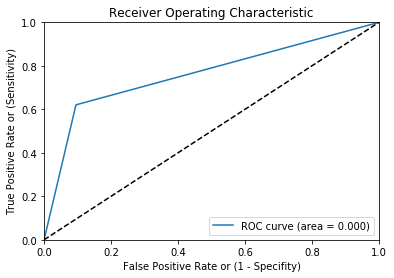

In [152]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = metrics.roc_curve(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster, pos_label=0)
roc_auc = 0# metrics.auc(manualtag_result_1.interdiscipilinary, manualtag_result_1.DBScanCluster)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [153]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]
merged_data['CategoryConv']=merged_data.Category.apply(CattoID)
merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [154]:
validation_part=manualtag[['Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(merged_data,how='left', left_on='Translates', right_on='Translates')

merged_data['validation_part']=False
merged_data['validation_part'][merged_data['Translates'].isin(manualtag['Translates'])]=True

Features=FeatureCols

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the DBScanCluster result. outlier data are considering as test data to reevaluate.
validation_part=validation_part[(validation_part.DBScanCluster!=0)]
X_Validation_DS=validation_part[Features]
validation_part['Category_1']=validation_part['Category_1'].apply(CattoID)
validation_part['Category_2']=validation_part['Category_2'].apply(CattoID)

X_Training_DS=merged_data[Features][(merged_data.DBScanCluster==0) ]
y_Training_DS=merged_data[OP_Feature][(merged_data.DBScanCluster==0) ]

X_Test_DS=merged_data[Features][(merged_data.DBScanCluster!=0) & (merged_data['validation_part']==False)]
y_Test_DS=merged_data[OP_Feature][(merged_data.DBScanCluster!=0) & (merged_data['validation_part']==False)]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.25, random_state=0)

/Users/balaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## 3.1  k-nearest neighbors 

In [171]:
kvalue=[]
test_accuracy=[]
test_precision=[]
validation_accuracy=[]
validation_precision=[]
cross_accuray=[]


for k in [4,6,10,16,25]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    
    val_preds=modelKBC.predict(X_Validation_DS)
    validation_part['val_preds']=val_preds
    y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)

    kvalue.append(k)
    test_accuracy.append( round( metrics.accuracy_score(y_test,y_pred),2) )
    test_precision.append(round(metrics.precision_score(y_test,y_pred, average='macro'),2) ) #, average='macro'
    
    validation_accuracy.append( round(metrics.accuracy_score(y_Validation_DS,val_preds),2) )
    validation_precision.append( round(metrics.precision_score(y_Validation_DS,val_preds, average='macro'),2) )
    
    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))
    #cross_accurayc
    
    print('neighbors:',k,'completed')


neighbors: 4 completed
neighbors: 6 completed
neighbors: 10 completed
neighbors: 16 completed
neighbors: 25 completed


In [172]:
kNNResult=pd.DataFrame({'kvalue':kvalue, 'test_accuracy':test_accuracy,'test_precision':test_precision, 'validation_accuracy':validation_accuracy,'validation_precision':validation_precision  })
kNNResult

,kvalue,test_accuracy,test_precision,validation_accuracy,validation_precision
0,4,0.84,0.82,0.70,0.72
1,6,0.85,0.83,0.63,0.68
2,10,0.86,0.84,0.63,0.68
3,16,0.87,0.85,0.63,0.68
4,25,0.87,0.85,0.67,0.70


In [176]:
k=4
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)

#nfolds=3
#scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
#pd.Series(scores).plot(kind="box", label="Accuracy");
#plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [177]:
# Print the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred, digits=3))

[[1238   69  385   67]
 [  39 1351   51   57]
 [ 259  115 2382  217]
 [  89  114  271 3842]]
              precision    recall  f1-score   support

           0      0.762     0.704     0.732      1759
           1      0.819     0.902     0.859      1498
           2      0.771     0.801     0.786      2973
           3      0.918     0.890     0.904      4316

    accuracy                          0.836     10546
   macro avg      0.818     0.824     0.820     10546
weighted avg      0.837     0.836     0.836     10546



In [178]:
val_preds=modelKBC.predict(X_Validation_DS)
validation_part['val_preds']=val_preds
y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)

# Print the confusion matrix
print(metrics.confusion_matrix(y_Validation_DS, val_preds))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_Validation_DS, val_preds, digits=2))


[[5 0 2 2]
 [1 6 0 1]
 [0 0 3 1]
 [0 0 2 7]]
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       1.00      0.75      0.86         8
           2       0.43      0.75      0.55         4
           3       0.64      0.78      0.70         9

    accuracy                           0.70        30
   macro avg       0.72      0.71      0.69        30
weighted avg       0.76      0.70      0.71        30



In [242]:
cvalue=[]
test_accuracy=[]
test_precision=[]
validation_accuracy=[]
validation_precision=[]
cross_accuray=[]


for x in [.01]+list(np.linspace(0.1,100,5))+[10]:

    modelSVC = svm.LinearSVC(C=x).fit(X_train, y_train)
    #### Hyper parameter ####
    # C - The strength of the regularization is inversely proportional to C.

    y_pred = modelSVC.predict(X_test)
    
    val_preds=modelSVC.predict(X_Validation_DS)
    validation_part['val_preds']=val_preds
    y_Validation_DS=validation_part[['val_preds','Category_1','Category_2']].apply(lambda x: x['Category_2'] if(x['Category_2']== x['val_preds']) else x['Category_1'] ,axis=1)

    cvalue.append(x)
    test_accuracy.append( round( metrics.accuracy_score(y_test,y_pred),2) )
    test_precision.append(round(metrics.precision_score(y_test,y_pred, average='macro'),2) )
    
    validation_accuracy.append( round(metrics.accuracy_score(y_Validation_DS,val_preds),2) )
    validation_precision.append( round(metrics.precision_score(y_Validation_DS,val_preds, average='macro'),2) )
    

/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/balaji/anaconda3/lib/python3.7/site-packag

In [243]:
SVCResult=pd.DataFrame({'cvalue':cvalue, 'test_accuracy':test_accuracy,'test_precision':test_precision, 'validation_accuracy':validation_accuracy,'validation_precision':validation_precision  })
SVCResult

,cvalue,test_accuracy,test_precision,validation_accuracy,validation_precision
0,0.010,0.85,0.85,0.37,0.09
1,0.100,0.86,0.85,0.37,0.09
2,25.075,0.85,0.85,0.37,0.09
3,50.050,0.85,0.85,0.37,0.09
4,75.025,0.84,0.85,0.37,0.09
5,100.000,0.84,0.84,0.37,0.09
6,10.000,0.86,0.85,0.37,0.09


## 4. Formatting the output categories based on the predict_proba

In [181]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [182]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''

In [183]:
PredictedValues['Category']=merged_data['Category']

In [184]:
fil_1_2=(PredictedValues['Category_12_Variance']<=.10) & ((PredictedValues['Category_1']==PredictedValues['Category']) | (PredictedValues['Category_2']==PredictedValues['Category']))
fil_2_3=(PredictedValues['Category_23_Variance']<=.10) & ((PredictedValues['Category_3']==PredictedValues['Category']) | (PredictedValues['Category_2']==PredictedValues['Category']))

PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_1']=PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category']
PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
PredictedValues.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

## 5.1. Validation with manual taggings

In [185]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:12]]], axis=1, ignore_index=False)

In [186]:
NewMergedDSAligned['DBScanCluster'].value_counts()

 0    42182
-1     8851
Name: DBScanCluster, dtype: int64

In [187]:
NewMergedDSAligned['DBScanCluster'][ NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']].value_counts()

-1    1623
 0     966
Name: DBScanCluster, dtype: int64

In [248]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=-1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Natural Sciences                  339
Engineering Sciences              298
Life Sciences                     263
Humanities and Social Sciences     66
Name: Category, dtype: int64

In [244]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster==-1) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Humanities and Social Sciences    588
Engineering Sciences              525
Natural Sciences                  415
Life Sciences                      95
Name: Category, dtype: int64

In [245]:
## regenerating dataset

MergeValidation=pd.concat([merged_data[['DBScanCluster','Translates']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)
MergeValidationResult_2=manualtag[['Category','Translates', 'Category_1', 'Category_2','interdiscipilinary']].merge(MergeValidation,how='left', left_on='Translates', right_on='Translates',suffixes= ('_Actual','_Pred'))


## Function to take a better results for valudation
def rebuilt_ip(x):
    final_pred=x['Category_1_Pred']
    final_actual=x['Category_1_Actual']
    result=0
    
    if(x['Category_1_Pred'] == x['Category_1_Actual']):
        final_pred=x['Category_1_Pred']
        final_actual=x['Category_1_Actual']
        result=1
        
    elif(x['Category_1_Pred'] == x['Category_2_Actual']):
        final_pred=x['Category_1_Pred']
        final_actual=x['Category_2_Actual']
        result=1
    
    elif(x['Category_2_Pred'] == x['Category_1_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_1_Actual']
        result=.66
        
    elif(x['Category_2_Pred'] == x['Category_2_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_2_Actual']
        result=.66
        
    elif(x['Category_3'] == x['Category_1_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_1_Actual'] 
        result=.33
        
    elif(x['Category_3'] == x['Category_2_Actual']):
        final_pred=x['Category_2_Pred']
        final_actual=x['Category_2_Actual']
        result=.33
    
    # if it is not an outlier assigning a original data sets
    if(x['DBScanCluster']!=-1):
        final_pred=x['Category_Actual']
        final_actual=x['Category_1_Actual']
        result=-1
    
    return pd.Series({'pred':final_pred,'actual':final_actual,'result':result})

MergeValidationResult_3=pd.concat([MergeValidationResult_2,pd.DataFrame(MergeValidationResult_2.apply(rebuilt_ip, axis=1))], axis=1)
MergeValidationResult_3['Match']=MergeValidationResult_3.apply(lambda x: 'Correct' if(x['pred']==x['Category_Actual']) else 'interdiscipilinary' , axis=1)


In [192]:
MergeValidationResult_3.groupby(['DBScanCluster','Match']).count()[['Translates']]

Translates
DBScanCluster Match                         
-1            Correct                     13
              interdiscipilinary          17
 0            Correct                     20

In [193]:
# Print the confusion matrix
print(metrics.confusion_matrix(MergeValidationResult_3.actual, MergeValidationResult_3.pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(MergeValidationResult_3.actual, MergeValidationResult_3.pred, digits=3))

[[11  0  0  2]
 [ 0 11  0  0]
 [ 0  3 15  1]
 [ 0  0  1  6]]
                                precision    recall  f1-score   support

          Engineering Sciences      1.000     0.846     0.917        13
Humanities and Social Sciences      0.786     1.000     0.880        11
                 Life Sciences      0.938     0.789     0.857        19
              Natural Sciences      0.667     0.857     0.750         7

                      accuracy                          0.860        50
                     macro avg      0.847     0.873     0.851        50
                  weighted avg      0.882     0.860     0.863        50



## 5.2. Each category TF/IDF based result evaluvation 

In [194]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [195]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [196]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [197]:
sizes=len(input_data.CategoryCollc.unique())
category_tfidfs=pd.DataFrame()

with tqdm(total=len(input_data['CategoryCollc'].unique())) as bar:
    for i,bucket in input_data.groupby(['CategoryCollc']):
        varcat=pd.DataFrame()

        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[[0,'Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        varcat['bucket_length']=len(bucket)
        varcat['bucket_category']=bucket['Category'].unique()[0]
        varcat['Category_1']=bucket['Category_1'].unique()[0]
        varcat['Category_2']=bucket['Category_2'].unique()[0]
        varcat['Category_3']=bucket['Category_3'].unique()[0]

        varcat['Category_1_Score']=bucket['Category_1_Values'].mean()
        varcat['Category_2_Score']=bucket['Category_2_Values'].mean()
        varcat['Category_3_Score']=bucket['Category_3_Values'].mean()

        varcat=varcat.reset_index()

        category_tfidfs=pd.concat([varcat[varcat.columns[1:]],category_tfidfs])
        bar.update(1)

100%|██████████| 62/62 [00:25<00:00,  2.43it/s]


In [198]:
category_tfidfs.to_csv(Path+'CategoryTFIDFSummary_WEPCADBScanFindingsKMeansV3.csv', index=False)

# Visualization

In [228]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:12]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=0)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=(cats_dist[i][j]+ cats_dist[j][i])/2
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-(pd.DataFrame(sym_dist, columns=cats, index=cats))

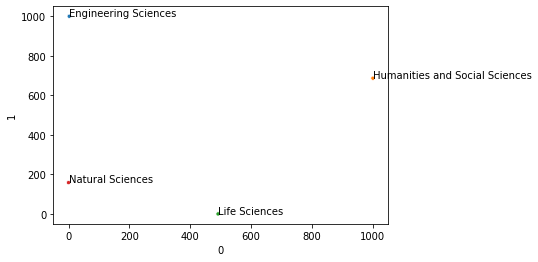

In [229]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

#coords = TSNE(n_components=2,perplexity=1.9, random_state=7, metric='precomputed').fit_transform(sym_dist)
coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [230]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.811730,0.803382,0.612576
Humanities and Social Sciences,0.811730,0.000000,0.628922,0.866549
Life Sciences,0.803382,0.628922,0.000000,0.483868
Natural Sciences,0.612576,0.866549,0.483868,0.000000


In [231]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,491.212919,0.000000,266.850419,715.575419,-134.617500,134.617500
1,Natural Sciences,171.5500,0.000000,158.326522,-171.550000,171.550000,55.396522,261.256522
2,Humanities and Social Sciences,124.8000,1000.000000,686.561273,875.200000,1124.800000,611.681273,761.441273
3,Engineering Sciences,117.2000,2.262259,1000.000000,-114.937741,119.462259,929.680000,1070.320000


In [232]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-02-23 12:44:07.891500 Started for Engineering Sciences
2020-02-23 12:44:28.275746 Completed for Engineering Sciences
2020-02-23 12:44:28.275949 Started for Humanities and Social Sciences
2020-02-23 12:44:57.487804 Completed for Humanities and Social Sciences
2020-02-23 12:44:57.488073 Started for Life Sciences
2020-02-23 12:45:45.741814 Completed for Life Sciences
2020-02-23 12:45:45.741966 Started for Natural Sciences
2020-02-23 12:46:23.327180 Completed for Natural Sciences


In [233]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


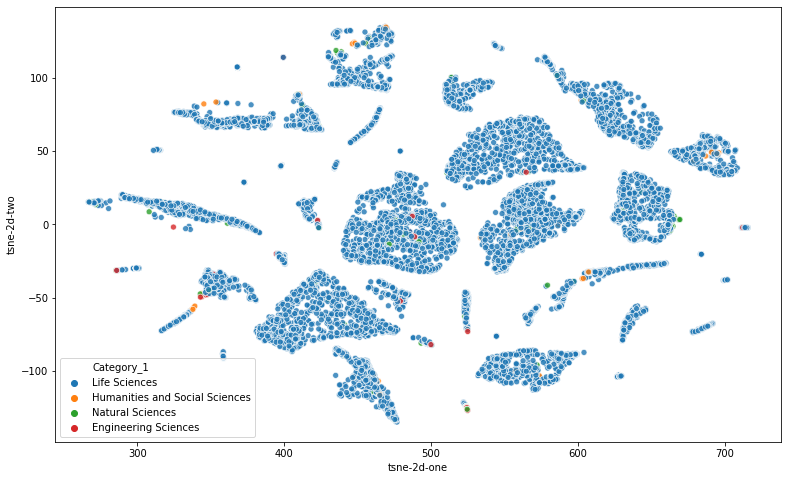

In [249]:
cat='Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'Engineering Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

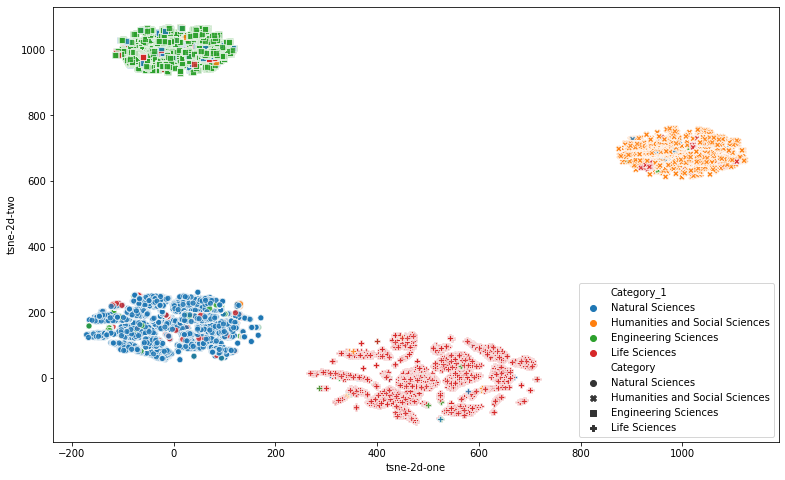

In [235]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [236]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.DBScanCluster==0)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','DBScanCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['DBScanCluster']!=0),'interdiscipilinary']=True

In [1]:
NewMergedDSAligned2.columns

NameError: name 'NewMergedDSAligned2' is not defined

In [237]:
Report_extrat['interdiscipilinary'].value_counts()

False    49410
True      1623
Name: interdiscipilinary, dtype: int64

In [247]:
Report_extrat[Report_extrat['interdiscipilinary']].Category.value_counts()

Humanities and Social Sciences    588
Engineering Sciences              525
Natural Sciences                  415
Life Sciences                      95
Name: Category, dtype: int64

In [238]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [246]:
Report_extrat.to_csv(Path+'Report_WEPCADBScanFindingsKMeansV3.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCADBScanFindingsKMeansV3.csv', index=False)